<a href="https://colab.research.google.com/github/riddhisahni/reddit_top_restaurants/blob/main/reddit_top_restaurants.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports and Installations

In [ ]:
! pip install praw vaderSentiment
! pip install openai==0.28
! pip install googlemaps folium
! pip install requests
! pip install transformers torch --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 189.3/189.3 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.5/76.5 kB 3.4 MB/s eta 0:00:00
  Attempting uninstall: openai
    Found existing installation: openai 1.76.2
    Uninstalling openai-1.76.2:
      Successfully uninstalled openai-1.76.2
  Preparing metadata (setup.py) ... done
  Created wheel for googlemaps: filename=googlemaps-4.10.0-py3-none-any.whl size=40714 sha256=5cff887f19814f21867fac26c4681fd770e286d8c8a521f9d7d5d10312c79453
  Stored in directory: /root/.cache/pip/wheels/f1/09/77/3cc2f5659cbc62341b30f806aca2b25e6a26c351daa5b1f49a
Successfully built googlemaps
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 82.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 65.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import os
import re
import json
import time
import praw
import openai
import folium
import random
import requests
import googlemaps
import unicodedata
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab import userdata
from transformers import pipeline
from collections import defaultdict
from googlemaps.exceptions import ApiError
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# API Initialization and Configuration

In [ ]:

reddit = praw.Reddit(
    client_id=userdata.get('REDDIT_CLIENT_ID'),
    client_secret=userdata.get('REDDIT_CLIENT_SECRET'),
    user_agent=userdata.get('REDDIT_USER_AGENT')
)

openai.api_key = userdata.get('OPENAI_API_KEY')
gmaps_key = userdata.get('GOOGLE_MAPS_API_KEY').strip()
gmaps = googlemaps.Client(key=gmaps_key)

# initialize sentiment analyzer and cache
analyzer = SentimentIntensityAnalyzer()
comment_cache = {}

sentiment_pipeline = pipeline("sentiment-analysis", model="nlptown/bert-base-multilingual-uncased-sentiment")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/953 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/669M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/39.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/872k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Device set to use cpu


# Helper Functions

In [ ]:
# normalize restaurant names by removing prefixes, stopwords, and standardizing format
def normalize_name(name):
    name = re.sub(r"^\s*[-–•\d\.]+\s*", "", name)
    name = name.lower().strip()
    stopwords = {"restaurant", "cafe", "bar", "the", "a", "an"}
    words = [w for w in name.split() if w not in stopwords]
    return " ".join(words)

# clean up restaurant names by removing extra characters, numbers, etc.
def clean_restaurant_name(name):
    name = name.lower().strip()
    name = re.sub(r'\s*\(.*?\)', '', name)
    name = re.sub(r'\s+\d+$', '', name)
    name = name.replace('’', "'")
    name = re.sub(r'[^\w\sæøåáéíóúñüÄÖäößØÆÅ-]', '', name, flags=re.UNICODE)
    name = re.sub(r'\s+', ' ', name)
    return name.strip()


# used to extract from JSON OpenAI returns during merging
def extract_json(text):
    try:
        match = re.search(r"\{[\s\S]*?\}", text)
        if match:
            raw = match.group(0)
            return json.loads(raw)
    except json.JSONDecodeError as e:
        print("JSON decode error:", e)
        print("Raw matched text:\n", raw)
    print("Could not extract valid JSON.")
    print("Full response:\n", text)
    return {}

# OpenAI Functions

In [ ]:
# Extract the restaurant names with OpenAI
def extract_restaurant_names(text):
    try:
        response = openai.ChatCompletion.create(
            model="gpt-4o",
            messages=[
                {"role": "system", "content": """You are a specialized restaurant name extraction system.
                Extract ONLY genuine restaurant, cafe, or bar names from the text.

                STRICT RULES:
                - Return ONLY restaurant, cafe, or bar establishments
                - EXCLUDE nightclubs, grocery stores, supermarkets, shops, venues, parks, etc.
                - Return one name per line with NO numbering or bullets
                - If no valid restaurants are mentioned, return "No restaurants found"
                - Remove any prefixes like numbers, dashes, or bullet points
                - Only return the name, not descriptions or addresses
                - EXCLUDE bars"""},
                {"role": "user", "content": f"Extract ONLY restaurant names from this text:\n\n{text}"}
            ],
            max_tokens=150,
            temperature=0.3
        )
        result = response.choices[0].message["content"].strip().split('\n')

        # Filter out "No restaurants found" responses
        if len(result) == 1 and "no restaurant" in result[0].lower():
            return []

        return [name.strip() for name in result if name.strip() and is_likely_restaurant(name.strip())]
    except Exception as e:
        print(f"GPT extraction error: {e}")
        return []

# Get the full, official restaurant names with OpenAI
def get_full_restaurant_names(short_names, city):
    if not short_names:
        return []

    try:
        response = openai.ChatCompletion.create(
            model="gpt-4o",
            messages=[
                {
                    "role": "system",
                    "content": (
                        f"You are a restaurant data specialist. "
                        f"Your task is to return the correct full names of restaurants as they would appear on Google Maps or the restaurant's official website. "
                        f"Ensure proper formatting and use of local characters, accents, and punctuation appropriate to the city of {city}. "
                        f"Avoid disclaimers or guesses — return your best confident guess even if unsure."
                    )
                },
                {
                    "role": "user",
                    "content": f"""For each restaurant name below, return only the correct full name as it would officially appear in {city}.
    Format: One restaurant per line. No numbering, no extra commentary.

    Restaurant names:
    {chr(10).join(short_names)}
    """
                }
            ],
            max_tokens=300,
            temperature=0
        )

        cleaned_list = response.choices[0].message["content"].strip().split('\n')
        return [name.strip() for name in cleaned_list if name.strip()]
    except Exception as e:
        print(f"GPT name enhancement error: {e}")
        return short_names  # Fall back to original names

# Cluster restaurants with similar names/spellings/abberviations together using OpenAI
def merge_equivalent_restaurant_names(name_list, city):
    if not name_list:
        return {}

    try:
        response = openai.ChatCompletion.create(
            model="gpt-4o",
            messages=[
                {
                    "role": "system",
                    "content": (
                        f"You are a restaurant name deduplication engine for {city}. "
                        "Your task is to group names that clearly refer to the same restaurant, even if they are misspelled, abbreviated, or contain different spellings (e.g., diacritics or translations)."
                        "Do not group names unless they are clearly referring to the exact same restaurant, not just similar cuisine or name patterns."
                    )
                },
                {
                    "role": "user",
                    "content": (
                        "Group the following restaurant name variants into arrays where all names refer to the same **actual restaurant**. "
                        "Only group names if they are truly aliases of the same place. If unsure, treat them as separate. "
                        "Use public web knowledge of restaurants in the city to guide you if needed.\n\n"
                        "Output only a valid JSON array of arrays. Do NOT include markdown or explanation.\n"
                        "Example format:\n"
                        "[\n"
                        "  [\"vaekst\", \"vækst\"],\n"
                        "  [\"lee's kitchen\", \"lees kitchen\", \"lee’s kitchen\"]\n"
                        "]\n\n"
                        "List to group:\n" + "\n".join(name_list)
                    )
                }
            ],
            temperature=0.2,
            max_tokens=2400
        )

        text = response.choices[0].message["content"]
        match = re.search(r"\[.*\]", text, re.DOTALL)

        if not match:
            print("Could not extract JSON from GPT response.")
            print("Full GPT response:\n", text)
            return {}

        raw_json = match.group(0)
        clusters = json.loads(raw_json)

        # Convert clusters into {variant → canonical}
        name_map = {}
        for group in clusters:
            if group:
                canonical = group[0].strip()
                for variant in group:
                    name_map[variant.strip().lower()] = canonical

        return name_map

    except Exception as e:
        print(f"GPT merge error: {e}")
        return {}

# Verfiy if it's a restaurant or not
def verify_restaurant_types(restaurant_names, city):
    if not restaurant_names:
        return []

    try:
        response = openai.ChatCompletion.create(
            model="gpt-4o",
            messages=[
                {"role": "system", "content": """You are a place-type classifier.

                For each name below, say YES if it's most likely a restaurant, cafe, bistro, or similar dining establishment — even if the name is unusual or playful.

                Say NO only if it's clearly a grocery store, nightclub, retail shop, or unrelated business.

                Use common sense and favor inclusion if unsure."""},
                {"role": "user", "content": f"""For each place in {city} listed below, indicate ONLY with 'YES' (if it's a restaurant, cafe, or bar) or 'NO' (if it's something else like a grocery store, nightclub, shop, etc.)

                Format your responses as:
                [Name]: YES/NO

                Places:
                {chr(10).join(restaurant_names)}
                """}
            ],
            max_tokens=300,
            temperature=0
        )

        result = response.choices[0].message["content"].strip()
        verified = []

        # Parse the response
        for line in result.split('\n'):
            if not line.strip():
                continue

            # Extract name and verification
            parts = line.split(':', 1)
            if len(parts) != 2:
                continue

            name = parts[0].strip().strip('[]')
            verification = parts[1].strip().upper()

            if verification == 'YES':
                verified.append(name)

        return verified
    except Exception as e:
        print(f"Restaurant verification error: {e}")
        return restaurant_names  # Fall back to original list

# Determine if the comment is a relevant restaurant related experience that should be used for sentiment analysis
def is_experience_comment(comment_text, restaurant_name):
    prompt = f"""Determine if the following Reddit comment expresses a clear opinion or personal experience about the restaurant "{restaurant_name}".

                Only respond with YES if the comment includes:
                - A personal opinion (positive or negative)
                - A mention of the restaurant with an impression or experience
                - A sentiment like "I’ve been disappointed", "I love it", or "always packed"

                Examples of valid comments:
                - "People keep recommending this but I’ve been disappointed every time"
                - "It’s always packed, must be good"
                - "Food was just okay"

                Respond with NO if the comment:
                - Is totally unrelated, off-topic, or does not refer to the restaurant experience at all.

                Examples of invalid comments:
                - "That lady was crazy at Poulette"
                - "I saw it on TikTok"
                - "It’s near my gym"

                Do NOT exclude short praise or emoji reactions if they clearly indicate a positive opinion.

                Only respond with YES or NO.

                Comment:
                \"{comment_text}\"
              """
    try:
        response = openai.ChatCompletion.create(
            model="gpt-4o",
            messages=[{"role": "user", "content": prompt}],
            max_tokens=3,
            temperature=0
        )
        answer = response.choices[0].message["content"].strip().lower()
        return "yes" in answer
    except Exception as e:
        print(f"GPT validation error: {e}")
        return False

# Restaurant Data Extraction

In [ ]:
# Non restaurant keywords to filter out
NON_RESTAURANT_KEYWORDS = {
    'grocery', 'supermarket', 'mall', 'shop', 'store', 'market',
    'nightclub', 'club', 'disco', 'venue', 'cinema', 'theater',
    'museum', 'gallery', 'park', 'library', 'school', 'university',
    'hospital', 'clinic', 'gym', 'fitness', 'pool', 'hotel', 'motel',
    'gas station', 'pharmacy', 'drugstore', 'department store'
}
#Gathering all of the posts from a city's subreddit
def gather_city_posts_from_city(city_name, num_posts=50):
    queries = [
        "restaurant", "restaurants", "food", "dinner", "lunch", "brunch",
        "where to eat", "best places", "good eats", "cheap eats"
    ]

    subreddit = reddit.subreddit(city_name.lower())
    collected_posts = []

    for query in queries:
        try:
            for post in subreddit.search(query, limit=20):
                if post not in collected_posts:
                    collected_posts.append(post)
                if len(collected_posts) >= num_posts:
                    return collected_posts
        except Exception as e:
            print(f"Error querying r/{city_name.lower()} with '{query}': {e}")

    return collected_posts

def gather_reddit_data(city_name, num_posts):
    post_sources = gather_city_posts_from_city(city_name, num_posts=num_posts)
    all_comments = []  # Initialize to store all comments
    for submission in post_sources:
        submission.comments.replace_more(limit=0)
        comments = submission.comments.list()
        random.shuffle(comments)
        all_comments.extend(comments[:30])  # Extend with limited comments
    return post_sources, all_comments

def is_likely_restaurant(name):
    name_lower = name.lower()

    # Check against non-restaurant keywords
    for keyword in NON_RESTAURANT_KEYWORDS:
        if keyword in name_lower:
            return False

    # Additional filters
    if (
        not name or
        name_lower.startswith("i'm sorry") or
        "no restaurant" in name_lower or
        len(name) < 3 or
        name.count(" ") > 5 or
        any(char in name for char in ["@", "#", "$", "%", "&", "*", "(", ")", "+", "="]) or
        re.search(r'\d{4,}', name)
    ):
        return False

    return True

# Sentiment Analysis

In [ ]:
# Sentiment analysis with Hugging Face (multilingual sentiment analysis)

# Determine raw sentiment for posts/comments
def analyze_restaurant_mentions(post_sources, all_comments):
    """Extracts and analyzes restaurant mentions and sentiment from posts and comments."""
    sentiments_raw = {}
    mentions_raw = {}
    experience_cache = {}
    comment_cache = {}
    processed_mentions = set()

    # Analyze posts
    for submission in post_sources:
        post_text = f"{submission.title}\n\n{submission.selftext}"
        post_restaurants = extract_restaurant_names(post_text)

        for restaurant in set(post_restaurants):  # Avoid duplicates in the post
            norm = normalize_name(restaurant)
            if not norm:
                continue

            # Check if this post and restaurant combination has been processed yet
            # If not, add it to the processed mentions and add sentiment to the sentiment dictionary
            if (submission.id, norm) not in processed_mentions:
                processed_mentions.add((submission.id, norm))
                mentions_raw.setdefault(norm, []).append({'text': post_text, 'source': 'post', 'url': submission.url})
                sentiments_raw.setdefault(norm, {'sum_sentiment': 0.0, 'count': 0})
                sentiments_raw[norm]['sum_sentiment'] += get_sentiment(post_text, restaurant)
                sentiments_raw[norm]['count'] += 1

        submission.comments.replace_more(limit=0)
        comments = submission.comments.list()

        #Get 30 random comments
        random.shuffle(comments)
        comments = comments[:30]

        #Get sentiment of comments
        for comment in comments:
            comment_text = comment.body.strip()
            if not comment_text:
                continue
            comment_restaurants = comment_cache.get(comment_text) or extract_restaurant_names(comment_text)
            comment_cache[comment_text] = comment_restaurants

            for restaurant in set(comment_restaurants):
                norm = normalize_name(restaurant)
                if not norm:
                    continue

                # Check if this comment and restaurant combination has been processed yet
                if (comment.id, norm) not in processed_mentions:
                    processed_mentions.add((comment.id, norm))
                    mentions_raw.setdefault(norm, []).append({'text': comment_text, 'source': 'comment', 'url': submission.url})
                    key = (comment_text, restaurant)
                    is_relevant = experience_cache.get(key)
                    if is_relevant is None:
                        is_relevant = is_experience_comment(comment_text, restaurant)
                        experience_cache[key] = is_relevant
                    if not is_relevant:
                        continue
                    sentiments_raw.setdefault(norm, {'sum_sentiment': 0.0, 'count': 0})
                    sentiments_raw[norm]['sum_sentiment'] += get_sentiment(comment_text, restaurant)
                    sentiments_raw[norm]['count'] += 1

    return sentiments_raw, mentions_raw

# Get relevent sentences from reddit and determine sentiment
def get_sentiment(text, restaurant_name=None):
    if restaurant_name and restaurant_name.lower() in text.lower():
        sentences = re.split(r'[.!?]+', text)
        relevant_sentences = [s.strip() for s in sentences if restaurant_name.lower() in s.lower()]

        # Determine whether the sentences are actually relevant (meaning they are actually talking about the restaurant, food, experience, etc.)
        filtered_sentences = []
        for s in relevant_sentences:
            if is_experience_comment(s, restaurant_name):
                filtered_sentences.append(s)

        if filtered_sentences:
            print(f"Relevant sentences for {restaurant_name}: {filtered_sentences}")
            sentiments = sentiment_pipeline(filtered_sentences)
        else:
            print(f"[Fallback] Using full text for sentiment: {text}")
            sentiments = sentiment_pipeline([text])
    else:
        sentiments = sentiment_pipeline([text])

    # sentiment score
    total = 0
    for result in sentiments:
        label = result['label']
        if label.startswith("1"):
            score = 1
        elif label.startswith("2"):
            score = 2
        elif label.startswith("3"):
            score = 3
        elif label.startswith("4"):
            score = 4
        elif label.startswith("5"):
            score = 5
        else:
            score = 0.0
        total += score

    return total / len(sentiments)

# Get Top Restaurants

In [ ]:
# Main function to actually get the top restaurants
def get_top_restaurants(city_name, num_posts=50, batch_size=5, min_mentions=1):

    subreddit_name = city_name.replace(" ", "")
    print(f"Searching for top restaurants in r/{subreddit_name}...")

    # Gather Reddit posts and comments
    post_sources, all_comments = gather_reddit_data(city_name, num_posts)

    # Extract and analyze restaurant mentions and sentiments
    sentiments_raw, mentions_raw = analyze_restaurant_mentions(post_sources, all_comments)

    # Clean, merge, and verify restaurant names
    merged_sentiments, merged_mentions, display_map = process_restaurant_names(sentiments_raw, mentions_raw, city_name)

    # Filter and sort restaurants based on sentiment and mentions
    final_top = filter_and_sort_restaurants(merged_sentiments, display_map, min_mentions, city_name)

    return merged_sentiments, list(display_map.values()), final_top

# Cleans, merges, and verifies restaurant names
def process_restaurant_names(sentiments_raw, mentions_raw, city_name):
    names_map = defaultdict(list)
    for name in sentiments_raw:
        clean_name = clean_restaurant_name(name) #clean the name
        names_map[clean_name].append(name) #Add variation of name (mapped to the clean name)

    # Uses GPT to group similar (clean) restaurant names in case the cleaning/merging process above does not adequately merge names together
    gpt_map = merge_equivalent_restaurant_names(list(names_map.keys()), city_name)

    final_name_map = defaultdict(list)
    for original_name, variants in names_map.items():
        merged_key = gpt_map.get(original_name, original_name)
        final_name_map[merged_key].extend(variants)

    merged_sentiments = {}
    merged_mentions = {}

    for clean_name, variants in final_name_map.items():
        merged_sentiments[clean_name] = {'sum_sentiment': 0.0, 'count': 0}
        merged_mentions[clean_name] = []
        for v in variants:
            merged_sentiments[clean_name]['sum_sentiment'] += sentiments_raw[v]['sum_sentiment']
            merged_sentiments[clean_name]['count'] += sentiments_raw[v]['count']
            merged_mentions[clean_name].extend(mentions_raw.get(v, []))

    # Get display/full restaurant names from GPT
    full_names = get_full_restaurant_names(list(merged_sentiments.keys()), city_name)
    display_map = {}
    for clean_name, full_name in zip(list(merged_sentiments.keys()), full_names):
        display_map[clean_name] = full_name.split(",")[0]

    for clean_name in merged_sentiments:
        if clean_name not in display_map:
            display_map[clean_name] = clean_name.title()
    return merged_sentiments, merged_mentions, display_map

def filter_and_sort_restaurants(merged_sentiments, display_map, min_mentions, city_name):

    qualified = {
        display_map.get(k, k.title()): v['sum_sentiment'] / v['count']
        for k, v in merged_sentiments.items()
        if v['count'] >= min_mentions and (v['sum_sentiment'] / v['count']) >= 5
    }

    top_restaurants = sorted(qualified.items(), key=lambda x: x[1], reverse=True)

    # Call OpenAI to confirm before finalizing the list that the restaurants are really restaurants
    verified_names = verify_restaurant_types([name for name, _ in top_restaurants], city_name)
    final_top = [(name, score, name) for name, score in top_restaurants if name in verified_names]
    return final_top

# Generate Map

In [ ]:
#Convert sentiment score to star rating (1-5).
def sentiment_to_stars(score):
    stars = int(score)
    return "⭐" * max(1, min(stars, 5))


# Get coordinates of restaurant
def get_coordinates(place_name, city=None):
    try:
        query = f"{place_name}, {city}" if city else place_name
        result = gmaps.places(query=query)

        if result['results']:
            location = result['results'][0]['geometry']['location']
            return (location['lat'], location['lng'])
        else:
            return None
    except Exception as e:
        print(f"Error fetching coordinates for {place_name}: {e}")
        return None

def generate_map_for_city(city, num_posts=30, batch_size=5):
    print(f"Generating restaurant map for {city}...")

    global sentiments, full_restaurant_names, top_restaurants

    # Get the top restaurants for the city
    sentiments, full_restaurant_names, top_restaurants = get_top_restaurants(city, num_posts=num_posts, batch_size=batch_size)

    if not top_restaurants:
        print(f"No restaurants found for {city}. Try increasing the number of posts to search.")
        return None

    # Print top restaurants with sentiment scores
    print(f"\nTop Restaurants in {city}:")
    print("=" * 40)

    for i, (short_name, score, full_name) in enumerate(top_restaurants, 1):
        stars = sentiment_to_stars(score)
        print(f"{i}. {full_name} — {stars} ({score:.2f})")

    # Set up map
    city_center = get_coordinates(city)
    if not city_center:
        print(f"Could not get coordinates for {city}")
        return None

    # Initialize Folium map centered around the city
    map_ = folium.Map(location=city_center, zoom_start=13)

    # Add restaurant pins to the map
    for short_name, score, full_name in top_restaurants:
        coords = get_coordinates(full_name, city)
        if coords:
            stars = sentiment_to_stars(score)
            popup_text = f"{full_name} — {stars} ({score:.2f})"
            folium.Marker(
                location=coords,
                popup=popup_text,
                icon=folium.Icon(color='red', icon='cutlery', prefix='fa')
            ).add_to(map_)

    return map_

# Analysis of Google vs Reddit Ratings

In [ ]:
# clean and format restaurant names for Google Places API
def format_restaurant_names(sentiments):
    return [f"{clean_restaurant_name(name)}" for name in list(sentiments.keys())]

# Get google places data for a restaurant (ratings)
def get_google_rating(restaurant_name, city, gmaps):
    try:
        places_result = gmaps.places(query=f"{restaurant_name}, {city}")

        if places_result['status'] == 'OK' and len(places_result['results']) > 0:
            place = places_result['results'][0]

            return {
                'rating': place.get('rating'),
                'review_count': place.get('user_ratings_total'),
                'price_level': place.get('price_level'),
                'types': place.get('types', [])
            }
        else:
            print(f"No results found for {restaurant_name}")
            return None

    except Exception as e:
        print(f"Error for {restaurant_name}: {e}")
        return None

def fetch_google_ratings(formatted_names, city, api_key):
    gmaps = googlemaps.Client(key=api_key)
    google_data = {}
    for formatted_name in formatted_names:
        result = get_google_rating(formatted_name, city, gmaps)
        if result:
            google_data[formatted_name] = {
                "rating": result.get('rating'),
                "review_count": result.get('review_count'),
                "price_level": result.get('price_level')
            }
        time.sleep(0.5)
    return google_data

# Creates a mapping between original and formatted restaurant names.
def create_name_mapping(sentiments, formatted_names):
    name_mapping = {}
    for i, orig_name in enumerate(sentiments.keys()):
        if i < len(formatted_names):
            name_mapping[orig_name] = formatted_names[i]
        else:
            name_mapping[orig_name] = orig_name
    return name_mapping

# Chat GPT generated dataframe with cuisines of top restaurants
cuisine_data = [
    ("chili grill kebab", "Middle Eastern"),
    ("gr-eat", "American, Fast Food"),
    ("burger shack", "American, Fast Food"),
    ("jah izakaya", "Japanese"),
    ("pizza d'italia", "Italian"),
    ("den lille fede", "Nordic, Fine Dining"),
    ("høst", "Nordic, Fine Dining"),
    ("café sommersko", "Café, European"),
    ("koefoed", "Nordic"),
    ("pho hanoi", "Vietnamese"),
    ("el tapeo de cervantes", "Spanish"),
    ("nihao yao", "Chinese"),
    ("alfredo's pizzaria", "Italian"),
    ("la carmela", "Italian"),
    ("kopan", "Korean"),
    ("spiseloppen", "European, Global"),
    ("punk royale", "Nordic, Fine Dining"),
    ("h table", "European, Fine Dining"),
    ("umi sushi", "Japanese, Sushi"),
    ("huang cheng", "Chinese"),
    ("figo", "Italian"),
    ("pizza huset", "Italian"),
    ("ninos", "Italian"),
    ("la vecchia signora", "Italian"),
    ("rufino osteria", "Italian"),
    ("souls", "Plant-Based"),
    ("ark", "Plant-Based, Fine Dining"),
    ("lupa", "Italian"),
    ("aamanns", "Nordic"),
    ("farms kitchen", "Farm to Table"),
    ("porn sak", "Thai"),
    ("ranees", "Indian"),
    ("captain h", "European, Seafood"),
    ("fu wa", "Chinese"),
    ("halvvejen", "Nordic"),
    ("pomodoro doro", "Italian"),
    ("cinco", "Latin American")
]

cuisine_df = pd.DataFrame(cuisine_data, columns=["formatted_name", "cuisine_types"])

# Combines Reddit sentiment data with Google ratings for a dataframe
def combine_restaurant_data(sentiments, google_data, name_mapping):
    price_map = {0: "$", 1: "$", 2: "$$", 3: "$$$", 4: "$$$$"}

    combined = []
    for restaurant_name, s_data in sentiments.items():
        formatted_name = name_mapping.get(restaurant_name, restaurant_name)
        sentiment = s_data["sum_sentiment"] / s_data["count"]
        count = s_data["count"]

        g_data = google_data.get(formatted_name, {})
        price_level = g_data.get("price_level")
        price_str = price_map.get(price_level, "N/A")

        combined.append({
            "restaurant": restaurant_name,
            "formatted_name": formatted_name,
            "reddit_mentions": count,
            "reddit_sentiment": round(sentiment, 3),
            "google_rating": g_data.get("rating"),
            "google_reviews": g_data.get("review_count"),
            "google_price": price_str  # <- this must match display function
        })
    return combined


# Create a formatted table of combined restaurant data
def display_restaurant_data(combined_data):
    df = pd.DataFrame(combined_data)
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', 200)

    print("\nCombined Restaurant Data:")
    print("-" * 200)
    print(f"{'No.':<4} {'Restaurant Name':<35} {'Google Rating':<14} {'Reddit Sentiment':<17} {'Mentions':<10} {'Reviews':<10} {'Price':<6} {'Cuisine'}")
    print("-" * 200)

    for i, row in df.iterrows():
        google_rating = f"{row['google_rating']:.1f}" if row['google_rating'] else "N/A"
        reddit_sentiment = f"{row['reddit_sentiment']:.2f}"
        cuisine = row.get('cuisine_types', 'Unknown')
        print(f"{i+1:<4} {row['formatted_name']:<35} {google_rating:<14} {reddit_sentiment:<17} "
              f"{row['reddit_mentions']:<10} {row['google_reviews'] or 'N/A':<10} {row['google_price']:<6} {cuisine}")
    print("-" * 200)

# Main function to create the dataframe of reddit and Google data
def analyze_restaurants(sentiments, city, api_key):
    formatted_names = format_restaurant_names(sentiments)
    google_data = fetch_google_ratings(formatted_names, city, api_key)
    name_mapping = create_name_mapping(sentiments, formatted_names)
    combined_data = combine_restaurant_data(sentiments, google_data, name_mapping)

    # Convert to DataFrame
    restaurant_df = pd.DataFrame(combined_data)

    # Merge in cuisine types
    restaurant_df = restaurant_df.merge(cuisine_df, on="formatted_name", how="left")
    restaurant_df["cuisine_types"] = restaurant_df["cuisine_types"].fillna("Unknown")

    # Display table
    display_restaurant_data(restaurant_df.to_dict("records"))
    formatted_names = restaurant_df['formatted_name'].tolist()

    return restaurant_df


# Copenhagen Results & Comparison with Google Reviews

In [ ]:
city = input("Enter a city to search for restaurants: ").strip()
start_time = time.time()

# Generate and display map
map_result = generate_map_for_city(city, num_posts=50, batch_size=5)
if map_result:
    display(map_result)

end_time = time.time()

elapsed_time = end_time - start_time
print(f"Time taken: {elapsed_time:.2f} seconds")


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



Generating restaurant map for copenhagen...
Searching for top restaurants in r/copenhagen...


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/l

Relevant sentences for Chili Grill Kebab: ['I’m not from the Middle East but I will say Chili Grill Kebab was one of the best Kebabs I’ve ever had']
Relevant sentences for GR-eat: ['GR-eat is great, as the name suggests, for Greek food']
Relevant sentences for Burger Shack: ['Burger Shack is a delicious burger I was surprised - Texas, USA']
Relevant sentences for Jah Izakaya: ['I actually think Jah Izakaya is some of the best japanese I’ve tried in Copenhagen']
Relevant sentences for Pizza D'Italia: ["Pizza D'Italia on Classensgade, I'd say it's the best in cph and especially for the price"]
Relevant sentences for Cofoco: ['Compare it to the chains of Cofoco or Madklubben and it is severel levels lower']
Relevant sentences for Madklubben: ['Compare it to the chains of Cofoco or Madklubben and it is severel levels lower']
Relevant sentences for Flammen: ['Just to tell the level of Flammen it\'s a place where i feel comfortable taking the kids and they don\'t have to sit still or "well b

Time taken: 1143.43 seconds


In [ ]:
# display time in minutes
print(f"Time taken: {elapsed_time/60:.2f} minutes")

Time taken: 19.06 minutes


In [ ]:
# Dataframe
results = analyze_restaurants(sentiments, city, gmaps_key)


Combined Restaurant Data:
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
No.  Restaurant Name                     Google Rating  Reddit Sentiment  Mentions   Reviews    Price  Cuisine
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
1    chili grill kebab                   4.8            5.00              1          391.0      $      Middle Eastern
2    gr-eat                              4.8            5.00              1          249.0      N/A    American, Fast Food
3    burger shack                        3.8            5.00              1          621.0      $$     American, Fast Food
4    jah izakaya                         4.4            5.00              1          767.0      

In [ ]:
results.columns

Index(['restaurant', 'formatted_name', 'reddit_mentions', 'reddit_sentiment', 'google_rating', 'google_reviews', 'google_price', 'cuisine_types'], dtype='object')

In [ ]:
# Due to expenses with OpenAI API, we had to hardcode this data again
# since it was not stored in the Google Places API and the original array was
# too specific.

cuisine_data_general = [
    ("chili grill kebab", "Middle Eastern"),
    ("gr-eat", "American"),
    ("burger shack", "American"),
    ("jah izakaya", "East Asian"),
    ("pizza d'italia", "Italian"),
    ("den lille fede", "Nordic"),
    ("høst", "Nordic"),
    ("café sommersko", "European"),
    ("koefoed", "Nordic"),
    ("pho hanoi", "East Asian"),
    ("el tapeo de cervantes", "Spanish"),
    ("nihao yao", "East Asian"),
    ("alfredo's pizzaria", "Italian"),
    ("la carmela", "Italian"),
    ("kopan", "East Asian"),
    ("spiseloppen", "European"),
    ("punk royale", "Nordic"),
    ("h table", "European"),
    ("umi sushi", "East Asian"),
    ("huang cheng", "East Asian"),
    ("figo", "Italian"),
    ("pizza huset", "Italian"),
    ("ninos", "Italian"),
    ("la vecchia signora", "Italian"),
    ("rufino osteria", "Italian"),
    ("souls", "Plant-Based"),
    ("ark", "Plant-Based"),
    ("lupa", "Italian"),
    ("aamanns", "Nordic"),
    ("farms kitchen", "American"),
    ("porn sak", "Southeast Asian"),
    ("ranees", "Indian"),
    ("captain h", "European"),
    ("fu wa", "East Asian"),
    ("halvvejen", "Nordic"),
    ("pomodoro doro", "Italian"),
    ("cinco", "Latin American")
]

# Create a mapping dictionary from cuisine_data
cuisine_map = {restaurant.lower(): cuisine for restaurant, cuisine in cuisine_data_general}

# Update the 'cuisine_types' column in the 'results' dataframe based on the restaurant names
results['cuisine_types'] = results['restaurant'].str.lower().map(cuisine_map).fillna(results['cuisine_types'])


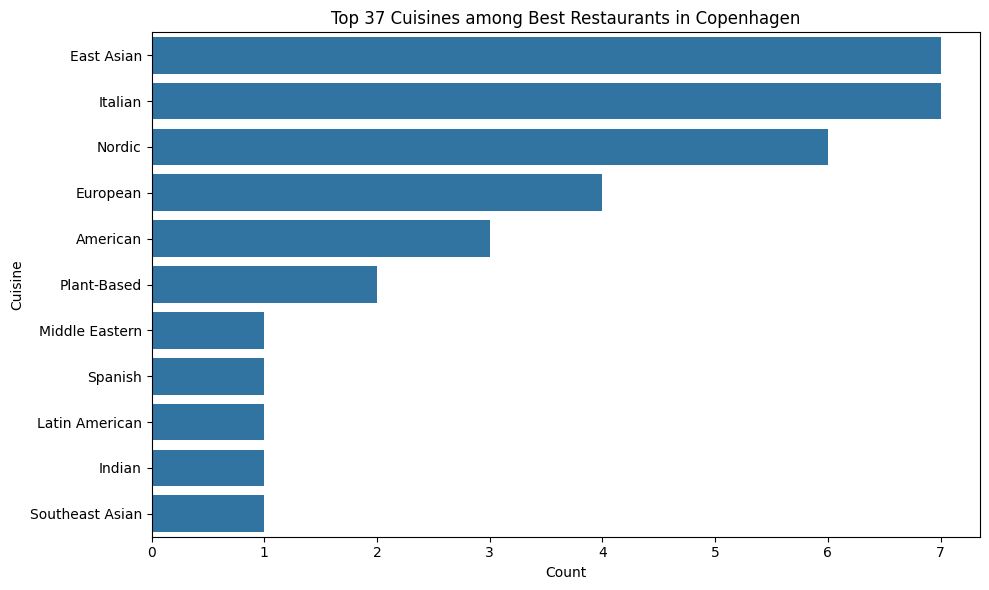

In [ ]:
# numeric version of price for calculations
results['Price_Numeric'] = results['google_price'].apply(lambda x: len(x))

# plot 1: cuisines among top restaurants

# Filter out rows with 'Unknown' cuisine
top_restaurants_filtered = top_restaurants[top_restaurants['cuisine_types'] != 'Unknown']

# plot 1: cuisines among top restaurants
plt.figure(figsize=(10, 6))
sns.countplot(data=top_restaurants_filtered, y='cuisine_types', order=top_restaurants_filtered['cuisine_types'].value_counts().index)
plt.title(f'Top {top_n} Cuisines among Best Restaurants in Copenhagen')
plt.xlabel('Count')
plt.ylabel('Cuisine')
plt.tight_layout()
plt.savefig('cuisine_distribution.png')
plt.show()



<ipython-input-75-7b6f55b51220>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


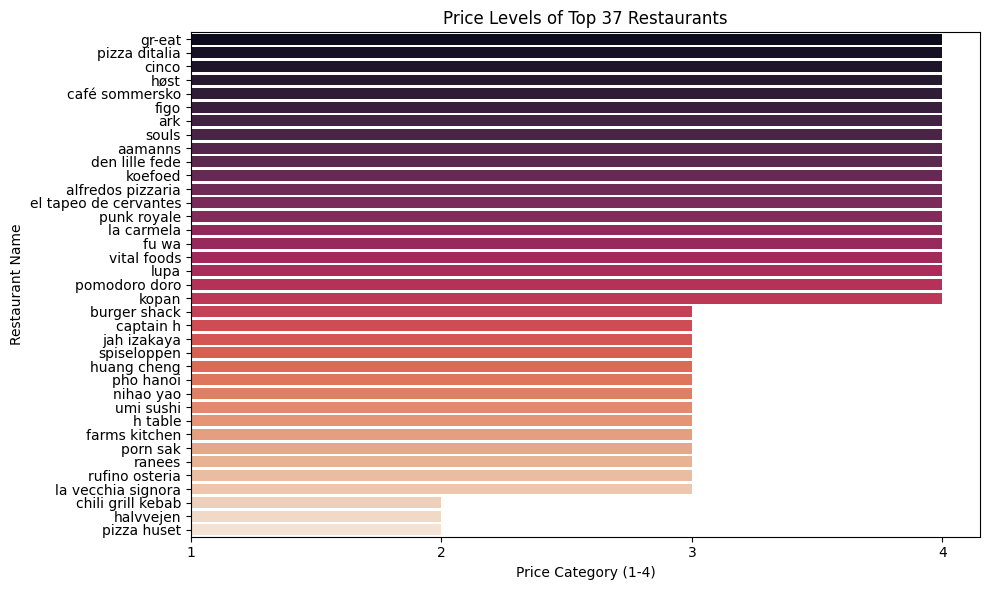

In [ ]:
# plot 2: price levels of top restaurants
plt.figure(figsize=(10, 6))
sns.barplot(
    data=top_restaurants.sort_values('Price_Numeric', ascending=False),
    x='Price_Numeric',
    y='formatted_name',
    palette='rocket'
)
plt.xticks(range(4), [1, 2, 3, 4])
plt.title(f'Price Levels of Top {top_n} Restaurants')
plt.xlabel('Price Category (1-4)')
plt.ylabel('Restaurant Name')
plt.tight_layout()
plt.show()

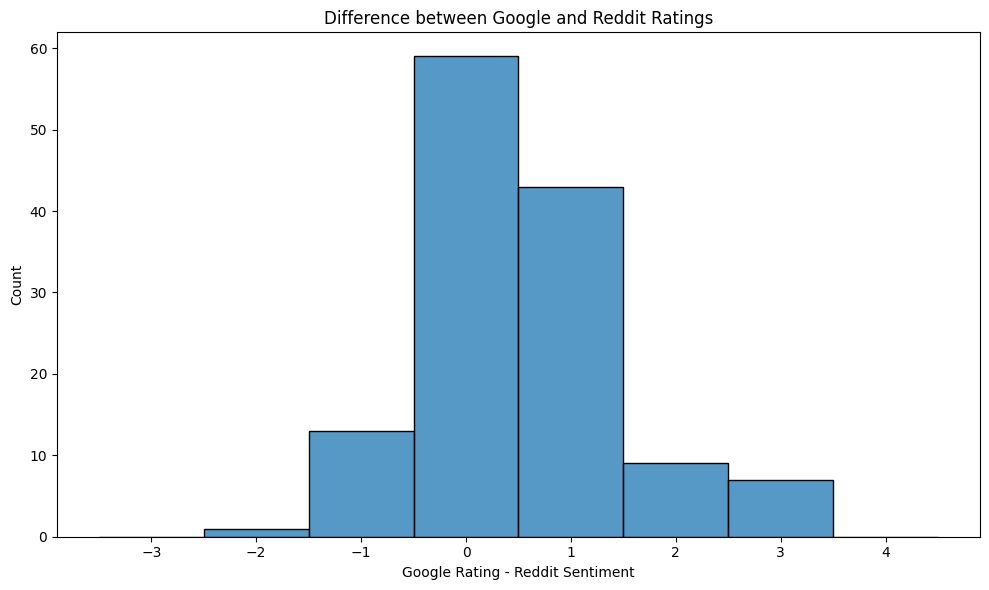

In [ ]:
# plot 3: differences between Google and Reddit ratings
min_diff = results['Rating Diff'].min()
max_diff = results['Rating Diff'].max()

bins = np.arange(np.floor(min_diff) - 0.5, np.ceil(max_diff)  + 1, 1)

plt.figure(figsize=(10, 6))
sns.histplot(
    results['Rating Diff'],
    bins=bins,
    kde=False
)

plt.xticks(np.arange(np.floor(min_diff), np.ceil(max_diff) + 1, 1))
plt.title('Difference between Google and Reddit Ratings')
plt.xlabel('Google Rating - Reddit Sentiment')
plt.tight_layout()
plt.savefig('rating_difference_centered.png')
plt.show()

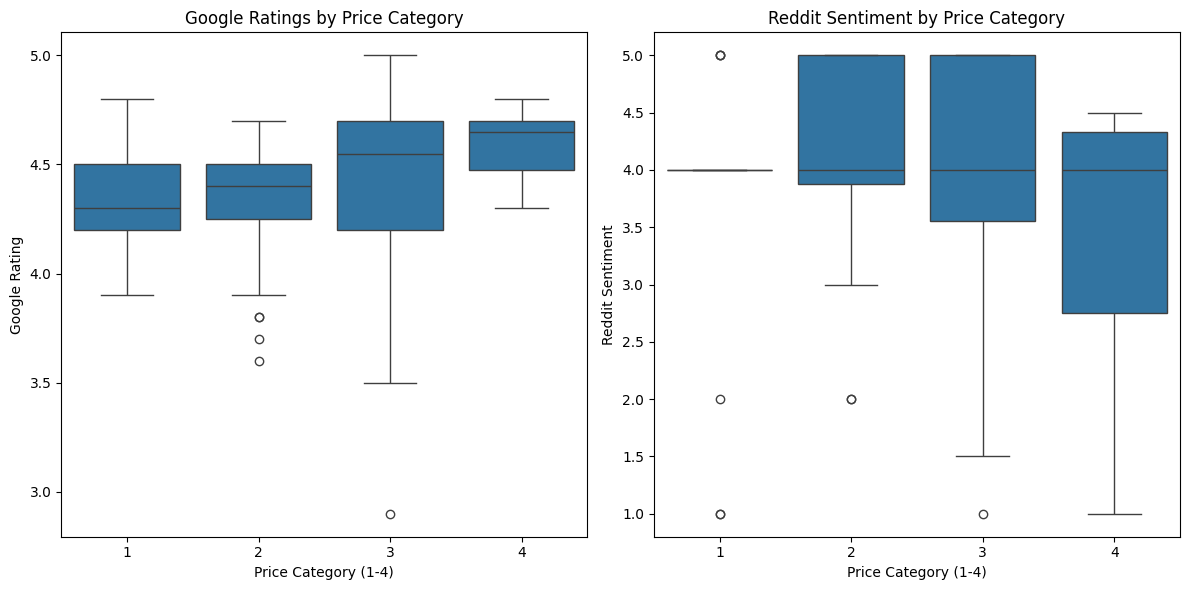

In [ ]:
# plot 4: compare price distribution vs. ratings
plt.figure(figsize=(12, 6))

# two subplots side by side
plt.subplot(1, 2, 1)
sns.boxplot(data=results, x='Price_Numeric', y='google_rating')
plt.xlabel('Price Category (1-4)')
plt.ylabel('Google Rating')
plt.title('Google Ratings by Price Category')
plt.xticks(range(4), [1, 2, 3, 4])

plt.subplot(1, 2, 2)
sns.boxplot(data=results, x='Price_Numeric', y='reddit_sentiment')
plt.xlabel('Price Category (1-4)')
plt.ylabel('Reddit Sentiment')
plt.title('Reddit Sentiment by Price Category')
plt.xticks(range(4), [1, 2, 3, 4])

plt.tight_layout()
plt.savefig('price_vs_ratings.png')
plt.show()

# Other Cities

In [ ]:
start_time = time.time()

# PARIS DATA
city = "Paris"

map_result = generate_map_for_city(city, num_posts=10, batch_size=5)
if map_result:
    display(map_result)

end_time = time.time()

# Calculate and print the time taken in minutes
time_taken = (end_time - start_time) / 60
print(f"Time taken: {time_taken:.2f} minutes")

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



Generating restaurant map for Paris...
Searching for top restaurants in r/Paris...


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/l

Relevant sentences for Bharat: ['My girlfriend is south Indian, we love to go to Bharat']
Relevant sentences for Aashiana: ['As an Indian living in Paris I’d recommend :\n\n1) Aashiana, Neuilly Sur Seine \n2) Khajuraho \n\nBoth are good, rest few less expensive ones near Gare du nord like few people said']
Relevant sentences for Khajuraho: ['As an Indian living in Paris I’d recommend :\n\n1) Aashiana, Neuilly Sur Seine \n2) Khajuraho \n\nBoth are good, rest few less expensive ones near Gare du nord like few people said']
Relevant sentences for Krishna Bhavan: ['My favourite is Krishna Bhavan which is vegetarian']
Relevant sentences for Desi Road: ['There\'s one called "Desi Road" which is quite good']
Relevant sentences for Mayfair Garden: ['My favorite restaurant in Paris is by far : Mayfair Garden']
[Fallback] Using full text for sentiment: Ashok Samrat, next to le Musée de l'air et de l'espace, out of Paris in Le Blanc-Mesnil. It is so far, but this is the best.
Relevant sentences f

Time taken: 3.35 minutes


In [ ]:
start_time = time.time()

# BARCELONA DATA
city = "barcelona"  # Replace with the city you want to search for

# Generate and display map
map_result = generate_map_for_city(city, num_posts=5, batch_size=5)
if map_result:
    display(map_result)

end_time = time.time()

time_taken = (end_time - start_time) / 60
print(f"Time taken: {time_taken:.2f} minutes")

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



Generating restaurant map for barcelona...
Searching for top restaurants in r/barcelona...


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/l

Relevant sentences for Chivuo's: ["\\+1 for Chivuo's, my favorite burger in Barcelona so far"]
Relevant sentences for el nacional: ['Agreed, been to el nacional a few times for example and the food was terrible']
Relevant sentences for Chivuo's: ["Chivuo's is great value"]
Relevant sentences for Asado Burger: ['IMO, Asado Burger has the best buttermilk fried chicken burger in Barcelona, also comes with a big side of good fries']
[Fallback] Using full text for sentiment: u/SR_RSMITH where is this guy btw now, do we know? I thought he would open another place. I believe he chose quality and slow life over quantity as this place started getting packed after a while. I was living next door and was buying from there since 2018 when the place was still not very known. indeed missed this place. Jon cake tried to copy him but quality and price is far behind from La mona.
Relevant sentences for Billy Brunch: ['I will never understand how people queue to eat at fcking Billy Brunch…']
Relevant se

Time taken: 2.06 minutes
